# Sparse Gaussian Process Regression

Here is a quick test of the Sparse Gaussian Process Regression (SGP) for the time-series of the slope $b$ for the cloud size distribution. This allows for a much faster 

In [45]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

# try:
#     import lib.config
# except Exception:
#     raise Exception("Issue with dynamic import")

# config = lib.config.read_config()
# pwd = Path(config["pwd"])
src = Path('../output')

In [46]:
# Import modules needed for the rest of the notebook
import numpy as np
import pandas as pd

import sklearn.preprocessing as skl_prep
from statsmodels.nonparametric import smoothers_lowess as sl

# Pytorch + GP
import torch, gpytorch

In [47]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

cp = sns.color_palette()

In [48]:
# CUDA setup
device = torch.device('cpu')
## Currently, a PyTorch bug prevents us from using CUDA
# if torch.cuda.is_available():
#     device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print(f"Using {device}")

Using cpu


# CGILS_S6 Slope Timeseries

 Let's load the dataset. We will be using a 12-hour data from CGILS case. It is rather unstable (due to the shallow ocean getting too hot too quickly), which is why I did a series of model runs to obtain a statically stable case. 

 The following method works perfectly well for CGILS_S6 case, which maintains good static stability over the entire 24-hour model run. Actually, I can often simply run the Gaussian Process regression with a periodic kernel to obtain its periodicity. However, this turns out to be a great showcase of how well the revised method holds against noisy, unstable timeseries. The entire workflow becomes much easier for CGILS since I don't have to worry about trends in the timeseries, but the results are consistent across many casees I tested.

In [49]:
p = Path('../output/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [50]:
y = df.slope.to_numpy()[:720]
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x, dtype=torch.double)
y_tr = torch.tensor(y, dtype=torch.double)

In [51]:
# We still need to normalize the data
y_tr = (y_tr - y_tr.min()) / (np.ptp(y_tr))

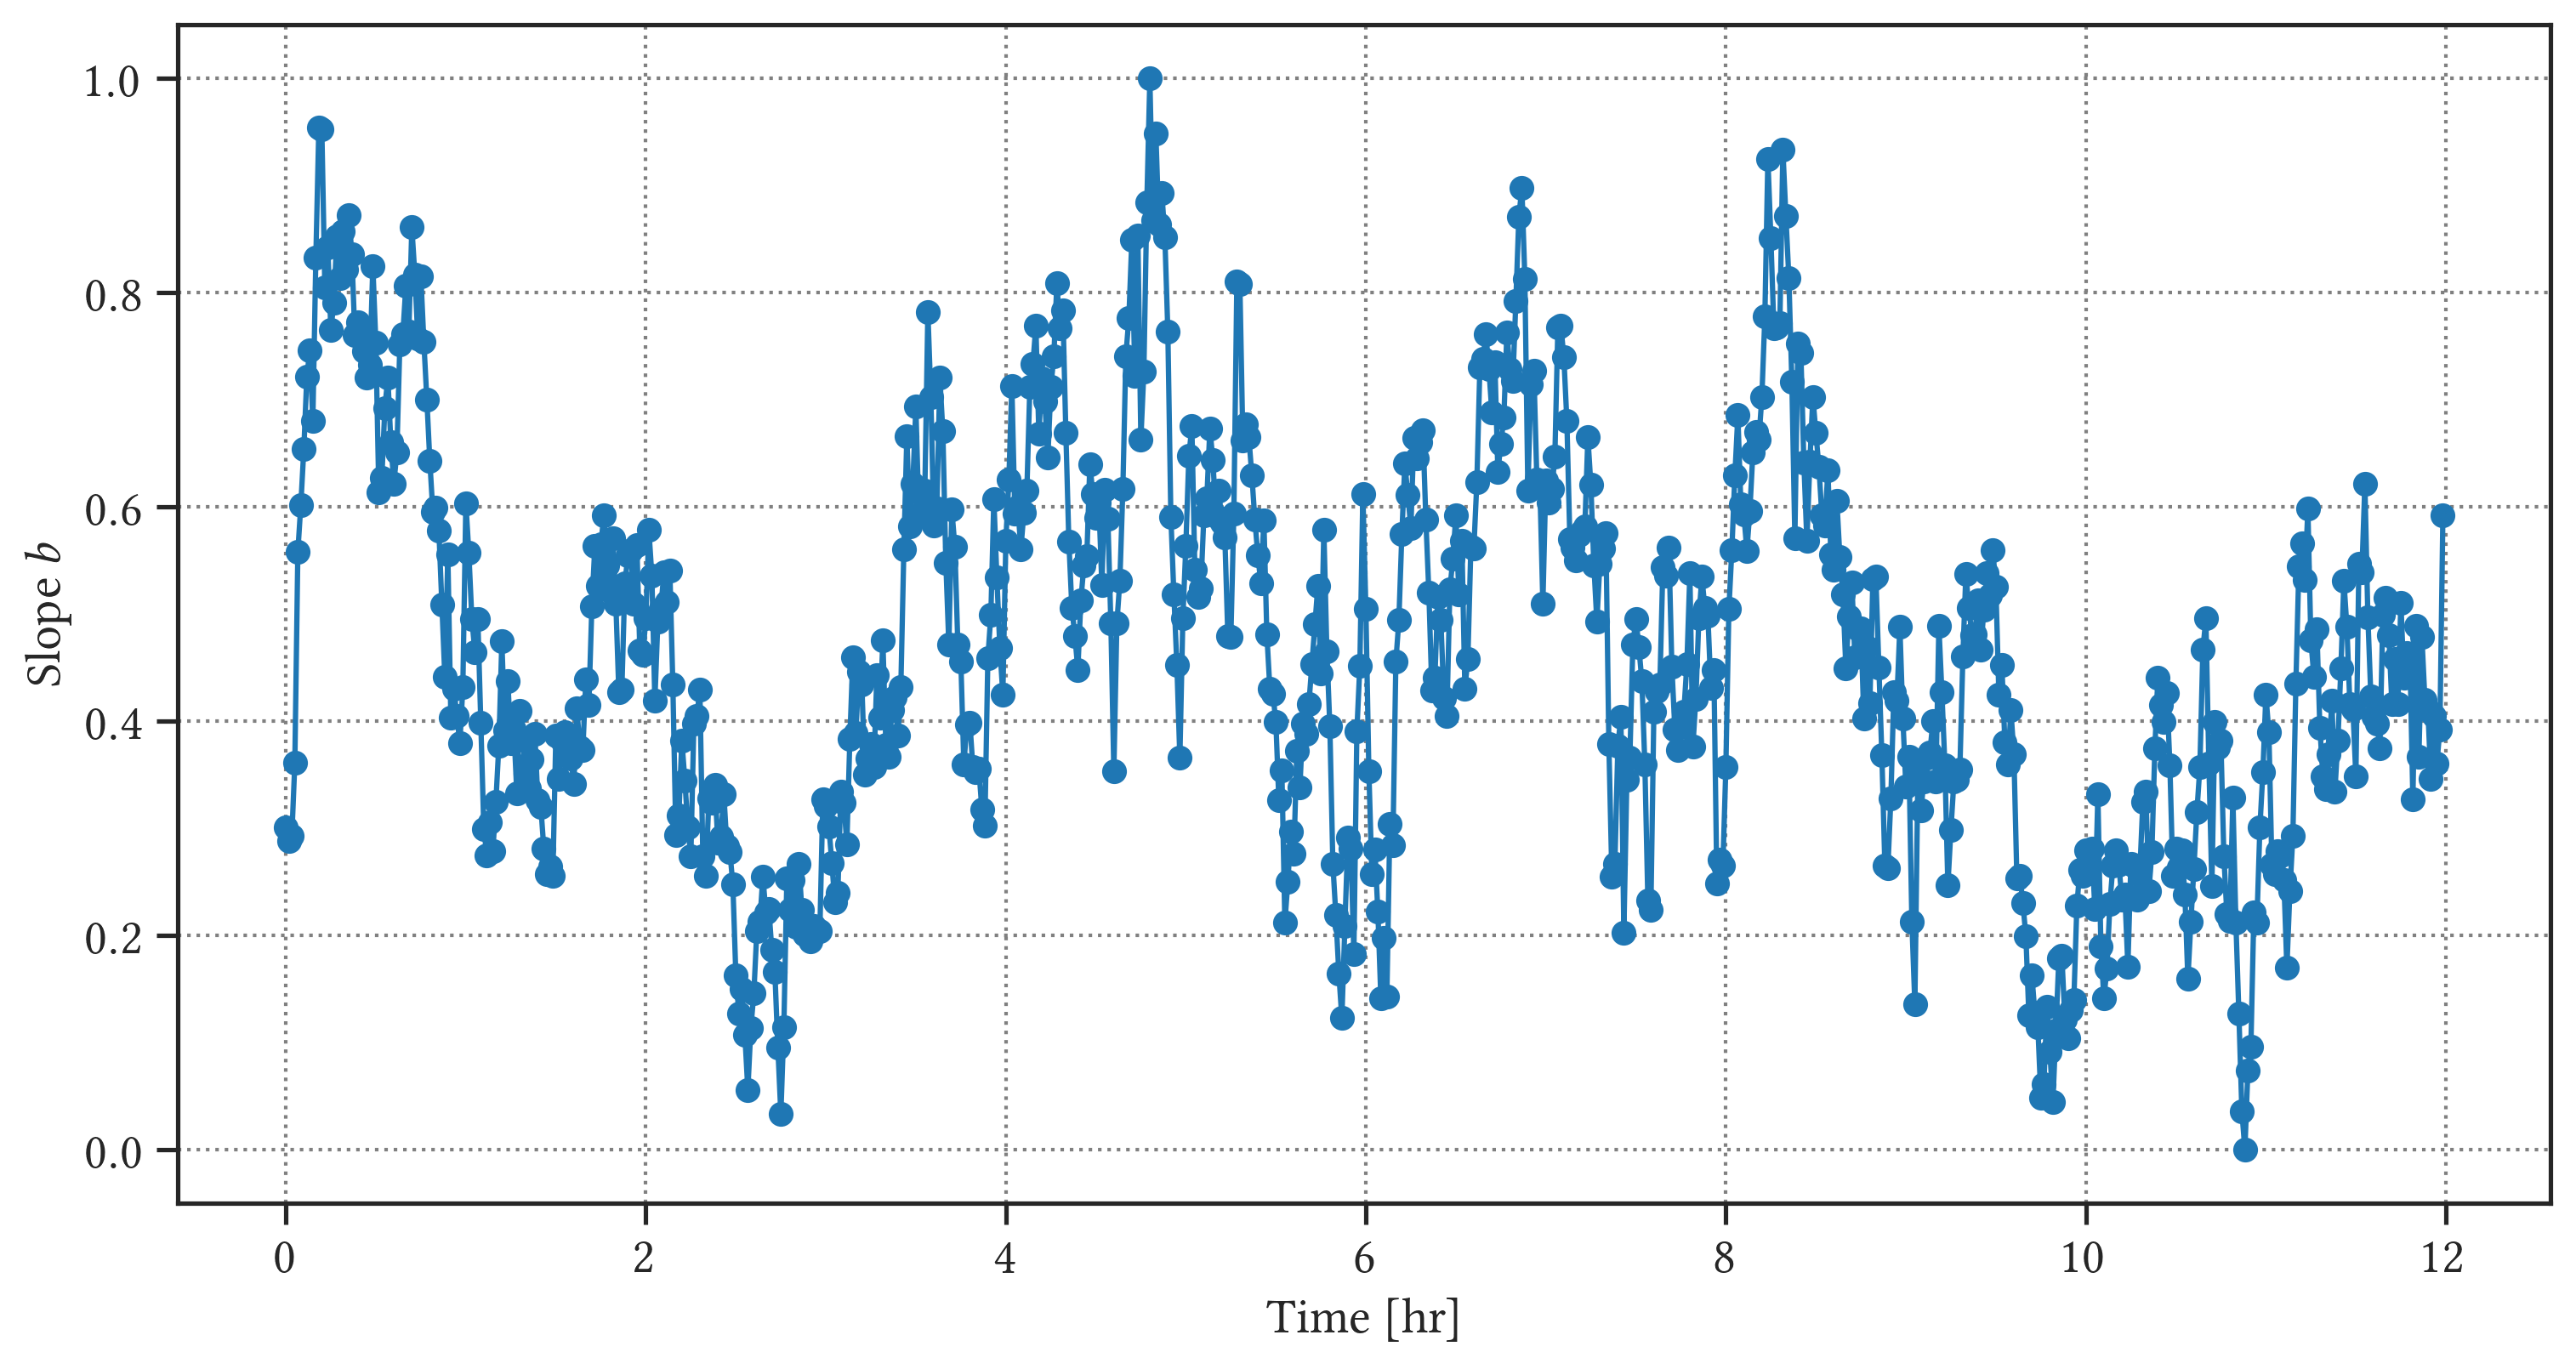

In [52]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)
ax.plot(x_tr / 60, y_tr, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

## GP Regression with Periodic Kernel

In [53]:
if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

In [54]:
# Sample inducing points from the training set
from numpy.random import default_rng

rng = default_rng()
sample = np.arange(len(x_tr))
rind = rng.choice(
    sample,
    int(len(sample) * 0.05),
    replace=False
)

ind_pts = x_tr.clone().detach()[sorted(rind)]


 Let's re-define the model. Now, we will only use a single periodic kernel with relatively smaller noise. The lengthscale parameter does not seem to matter too much, and I can use a 90-minute periodicity as a prior based on the results from the previous GP regression.

In [55]:
class SparseGP(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SparseGP, self).__init__(x_tr, y_tr, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        self.base_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

        self.cov_module = gpytorch.kernels.InducingPointKernel(
            self.base_module, inducing_points=ind_pts, likelihood=likelihood
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)

        return gpytorch.distributions.MultivariateNormal(
            x_mean, x_cov, validate_args=True
        )


In [56]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.Positive(),
    noise_prior = gpytorch.priors.NormalPrior(1e-4, 1e-2),
)
model = SparseGP(x_tr, y_tr, likelihood)

model.base_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(1e2)
)

model.base_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(1e2),
    period_length = torch.tensor(90.),
)

model.double()

SparseGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ConstantMean()
  (base_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
  (cov_module): InducingPointKernel(
    (base_kernel): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): RBFKernel(
            (raw_lengthscale_constraint): Positive()
          )
          (raw_outputscale_constraint): Positive()
        )
        (1): ScaleKernel(
  

In [57]:
# Model parameters
for param_name, param in model.named_parameters():
    try:
        print(f"{param_name:42} \t {param.item()}")
    except:
        pass

likelihood.noise_covar.raw_noise           	 0.0
mean_module.raw_constant                   	 0.0
base_module.kernels.0.raw_outputscale      	 0.0
base_module.kernels.0.base_kernel.raw_lengthscale 	 100.0
base_module.kernels.1.raw_outputscale      	 0.0
base_module.kernels.1.base_kernel.raw_lengthscale 	 100.0
base_module.kernels.1.base_kernel.raw_period_length 	 90.0


In [58]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 150
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    period = model.base_module.kernels[1].base_kernel.raw_period_length.item()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f} Period: {period:.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/150 [00:00<?, ?it/s]

/home/loh/.local/conda/envs/stats/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [59]:
# Model parameters
for param_name, param in model.named_parameters():
    try:
        print(f"{param_name:42} \t {param.item()}")
    except:
        pass

likelihood.noise_covar.raw_noise           	 -4.357243092966917
mean_module.raw_constant                   	 0.12161542964520033
base_module.kernels.0.raw_outputscale      	 4.780150268274
base_module.kernels.0.base_kernel.raw_lengthscale 	 83.09917902806399
base_module.kernels.1.raw_outputscale      	 -0.6952040168677196
base_module.kernels.1.base_kernel.raw_lengthscale 	 92.67414779986865
base_module.kernels.1.base_kernel.raw_period_length 	 96.90262630568388


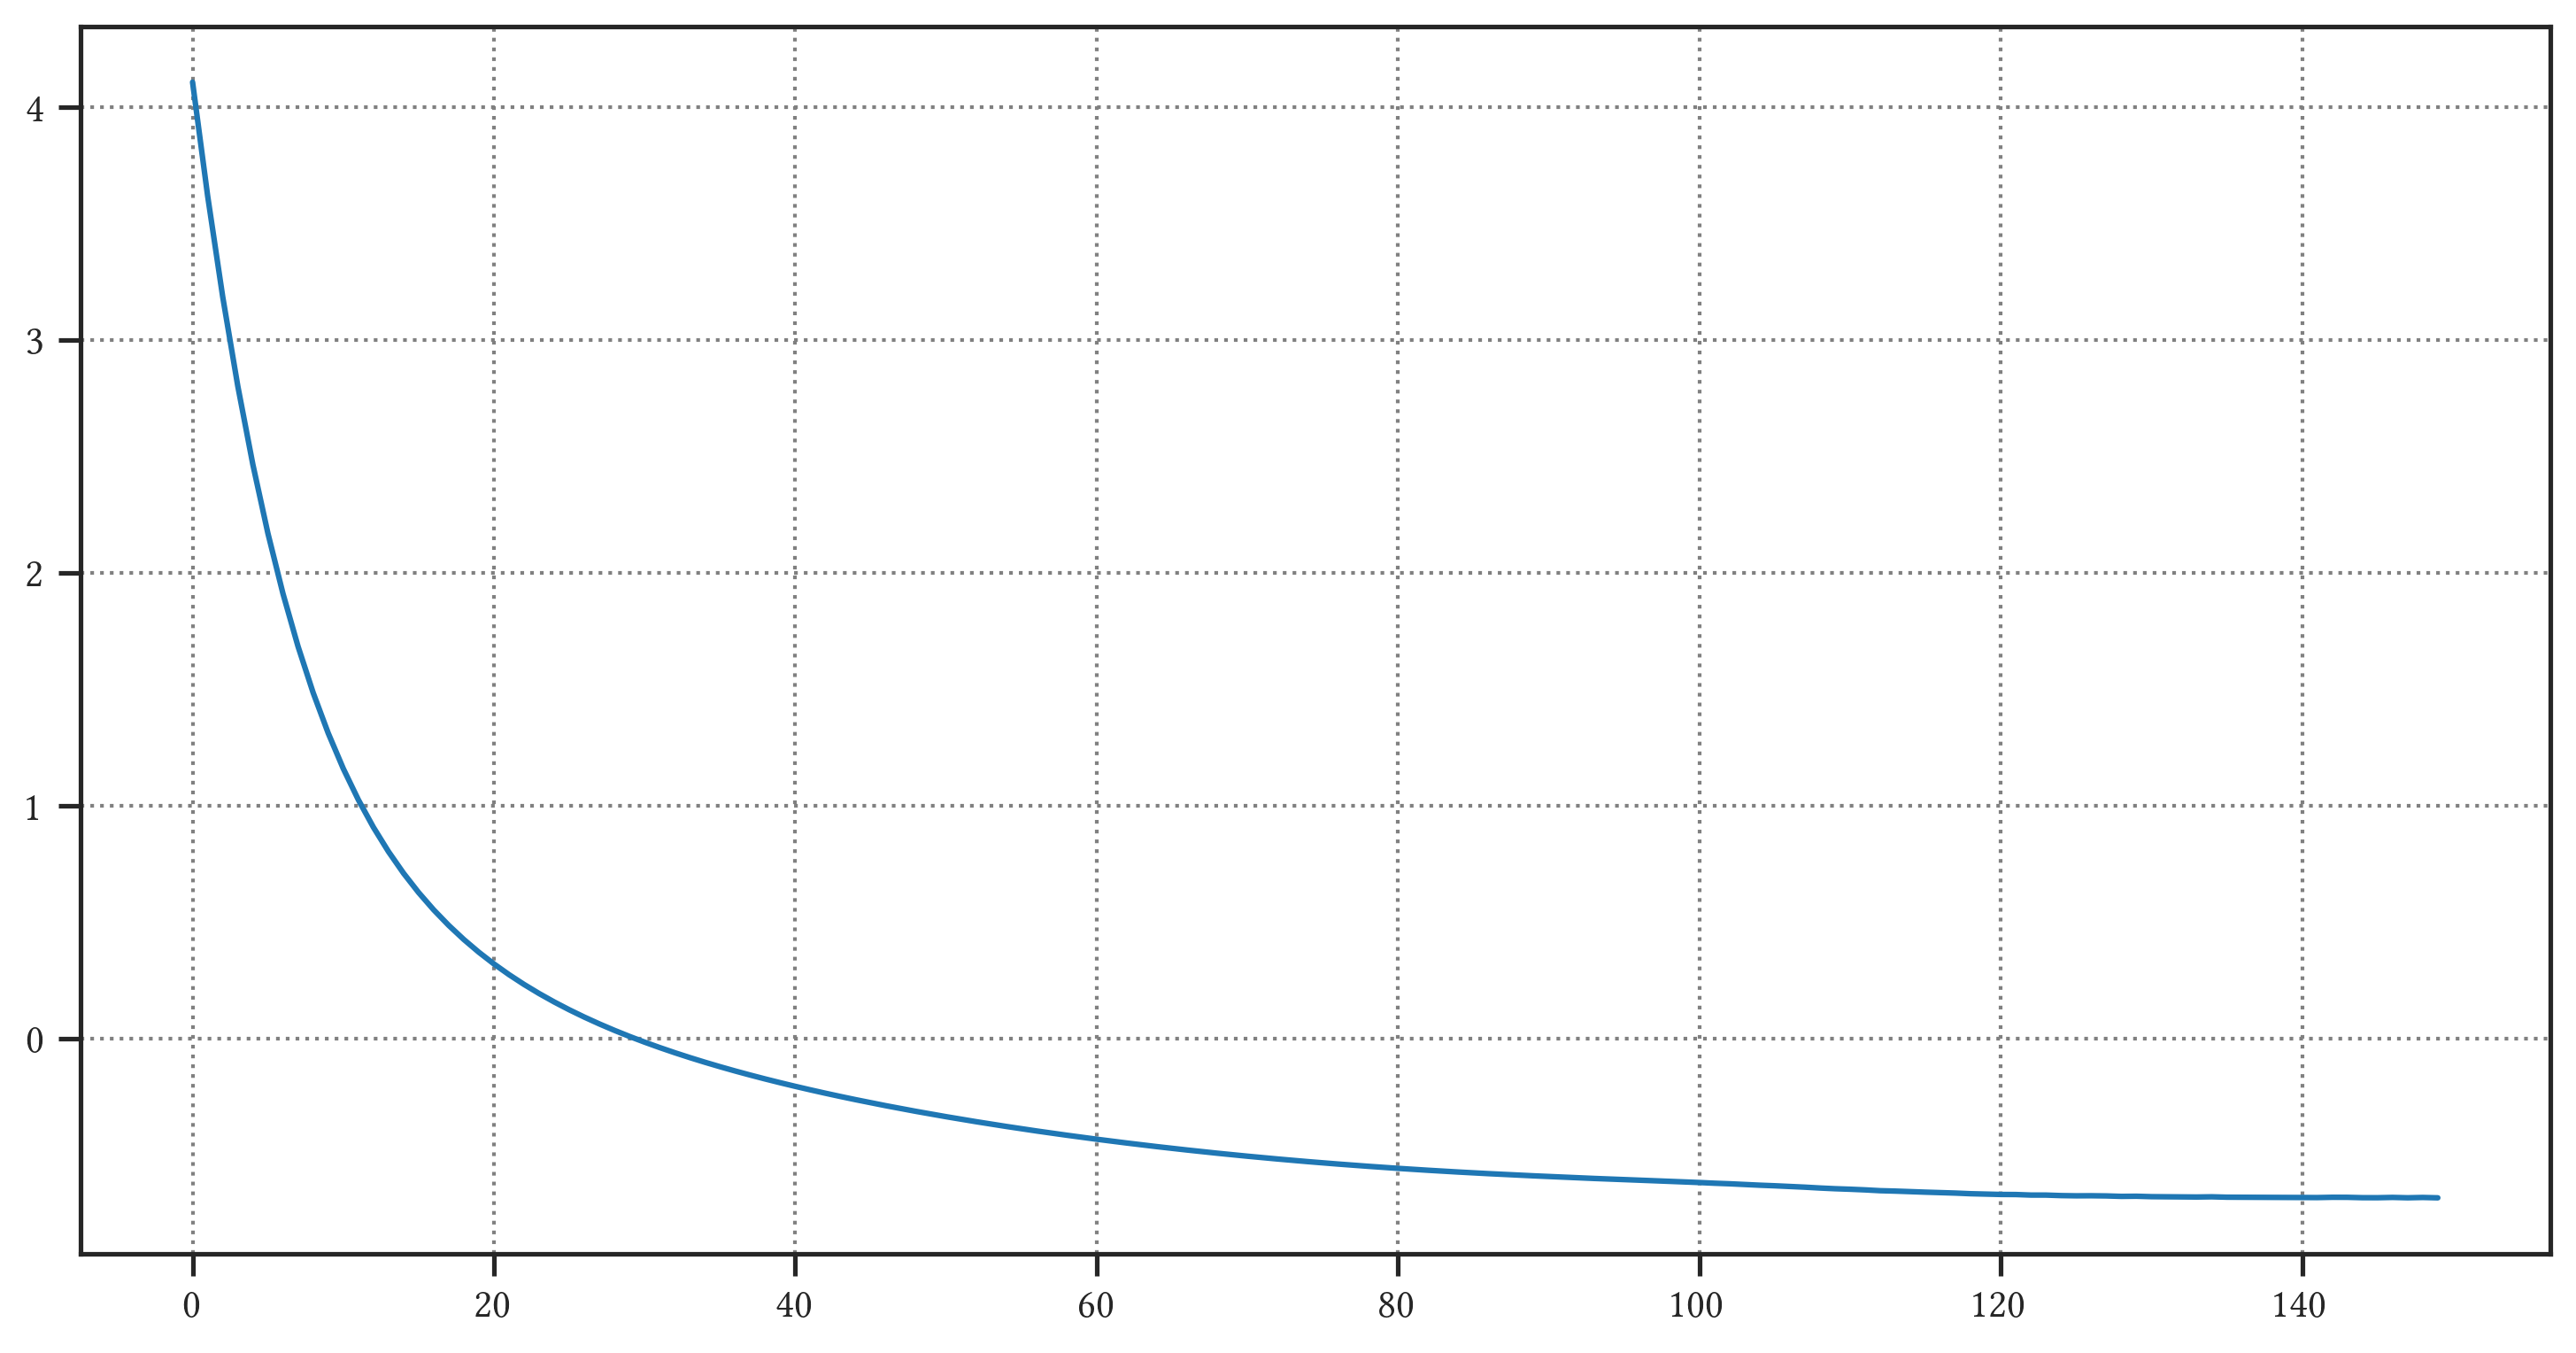

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [61]:
dt = 180

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()


In [62]:
if device.type == "cuda":
    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

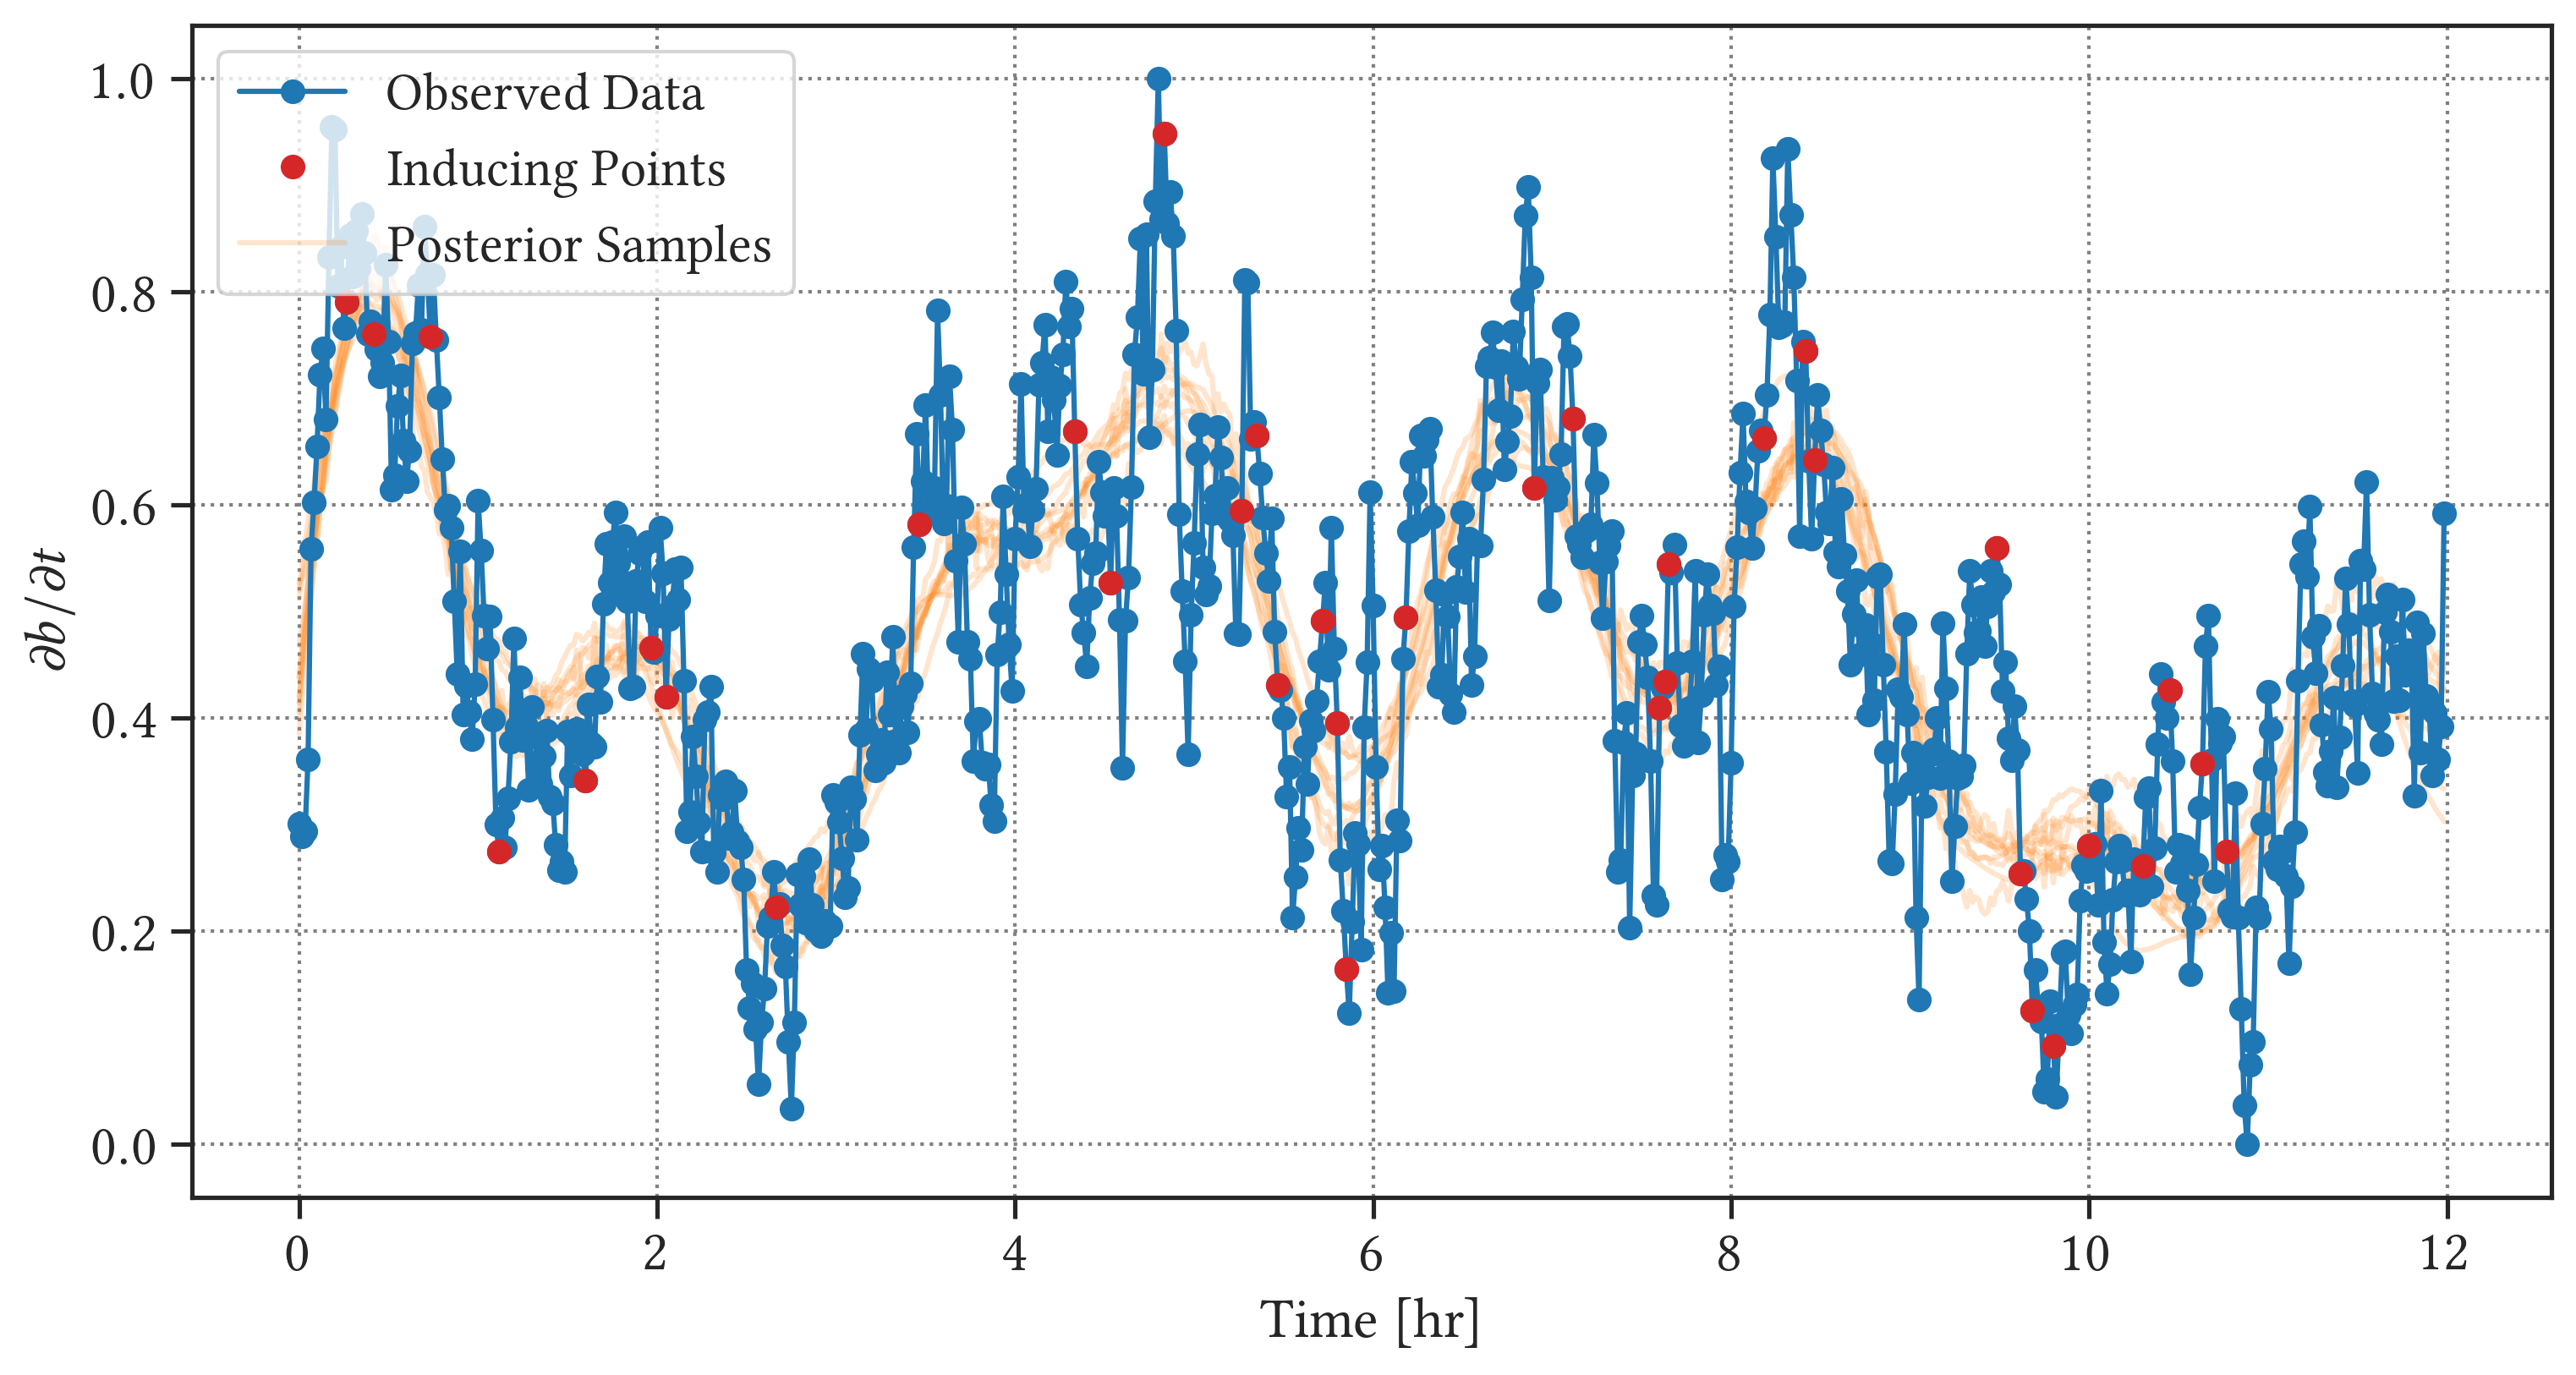

In [63]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr[:720] / 60, y_tr[:720], "o-", c=cp[0], zorder=5)
ax.plot(x_tr[:720][sorted(rind)] / 60, y_tr[:720][sorted(rind)], "o", c=cp[3], zorder=5)

for i in range(10):
    ax.plot(x_test[:720] / 60, observed.sample()[:720].cpu(), alpha=0.2, c=cp[1])

ax.legend(
    ["Observed Data", "Inducing Points", "Posterior Samples"],
    loc=2,
    fontsize=15,
)

ax.set_xlabel("Time [hr]", fontsize=16)
ax.set_ylabel("$\partial b / \partial t$", fontsize=16)

ax.tick_params(axis="both", which="major", labelsize=16)


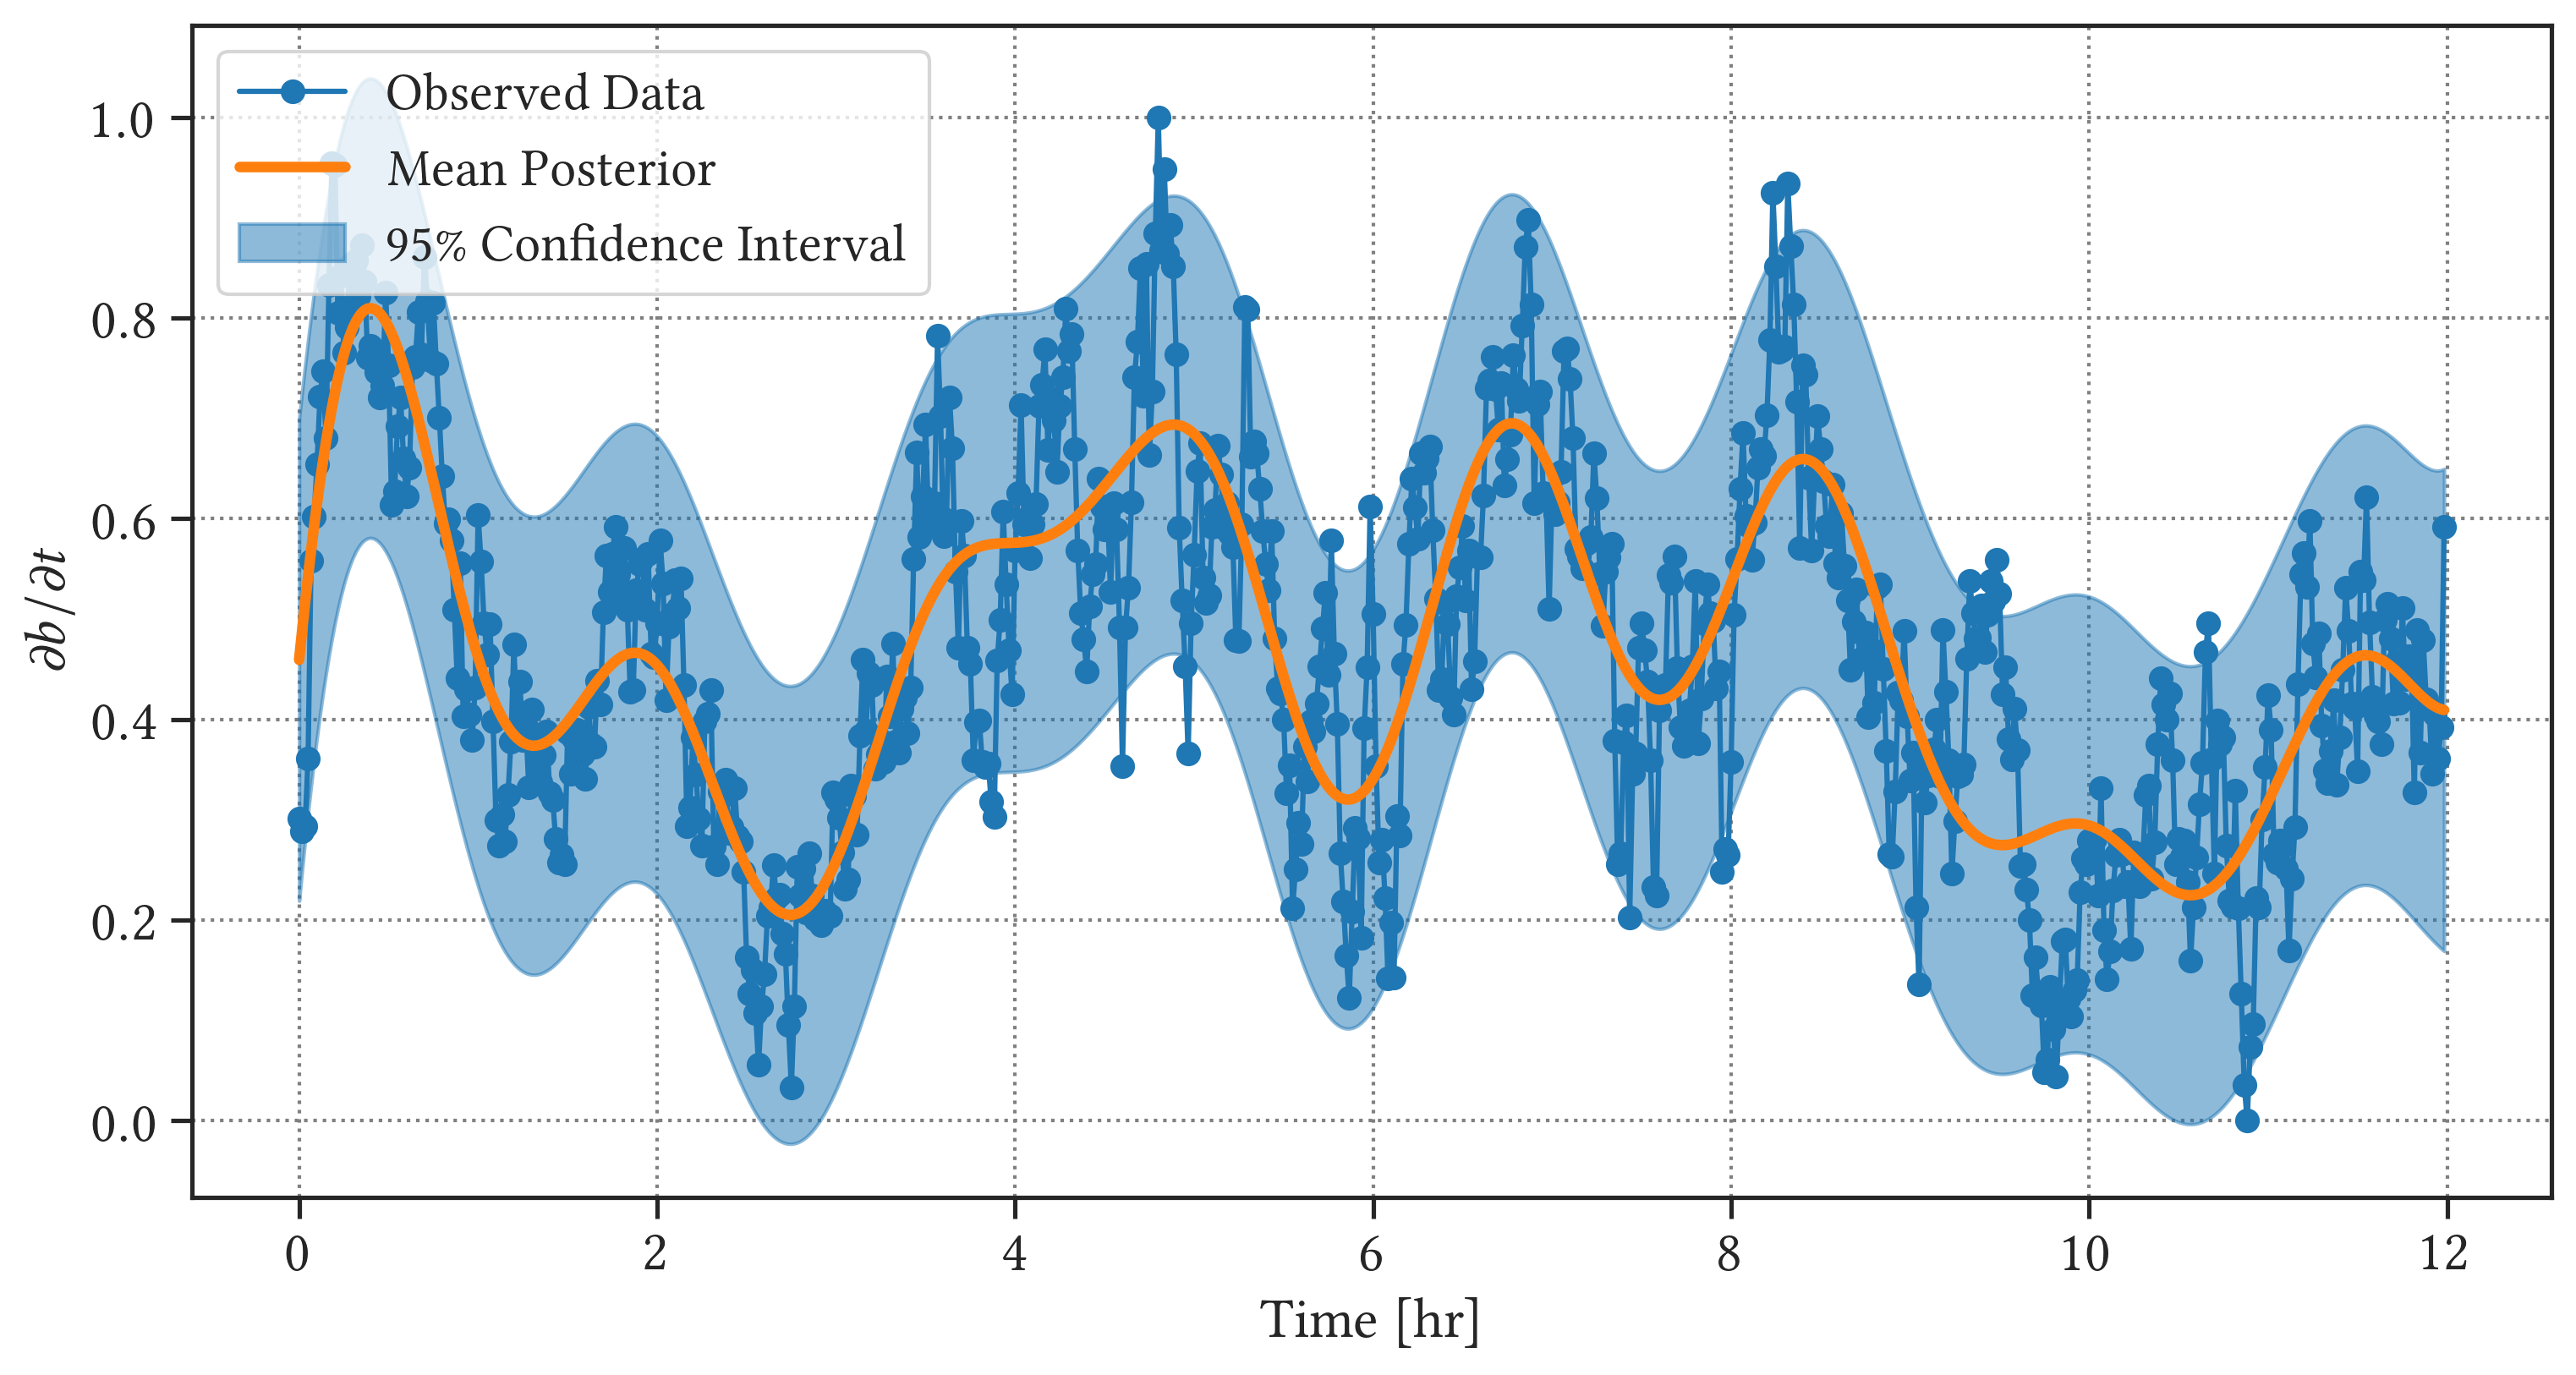

In [64]:
# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_tr[:720] / 60, y_tr[:720], "o-", c=cp[0])
ax.plot(x_test[:720] / 60, y_mean[:720], c=cp[1], lw=3)
ax.fill_between(x_test[:720] / 60, lower[:720], upper[:720], alpha=0.5, color=cp[0])

ax.legend(
    ["Observed Data", "Mean Posterior", "95\% Confidence Interval"],
    loc=2,
    fontsize=15,
)

ax.set_xlabel("Time [hr]", fontsize=16)
ax.set_ylabel("$\partial b / \partial t$", fontsize=16)

ax.tick_params(axis="both", which="major", labelsize=16)


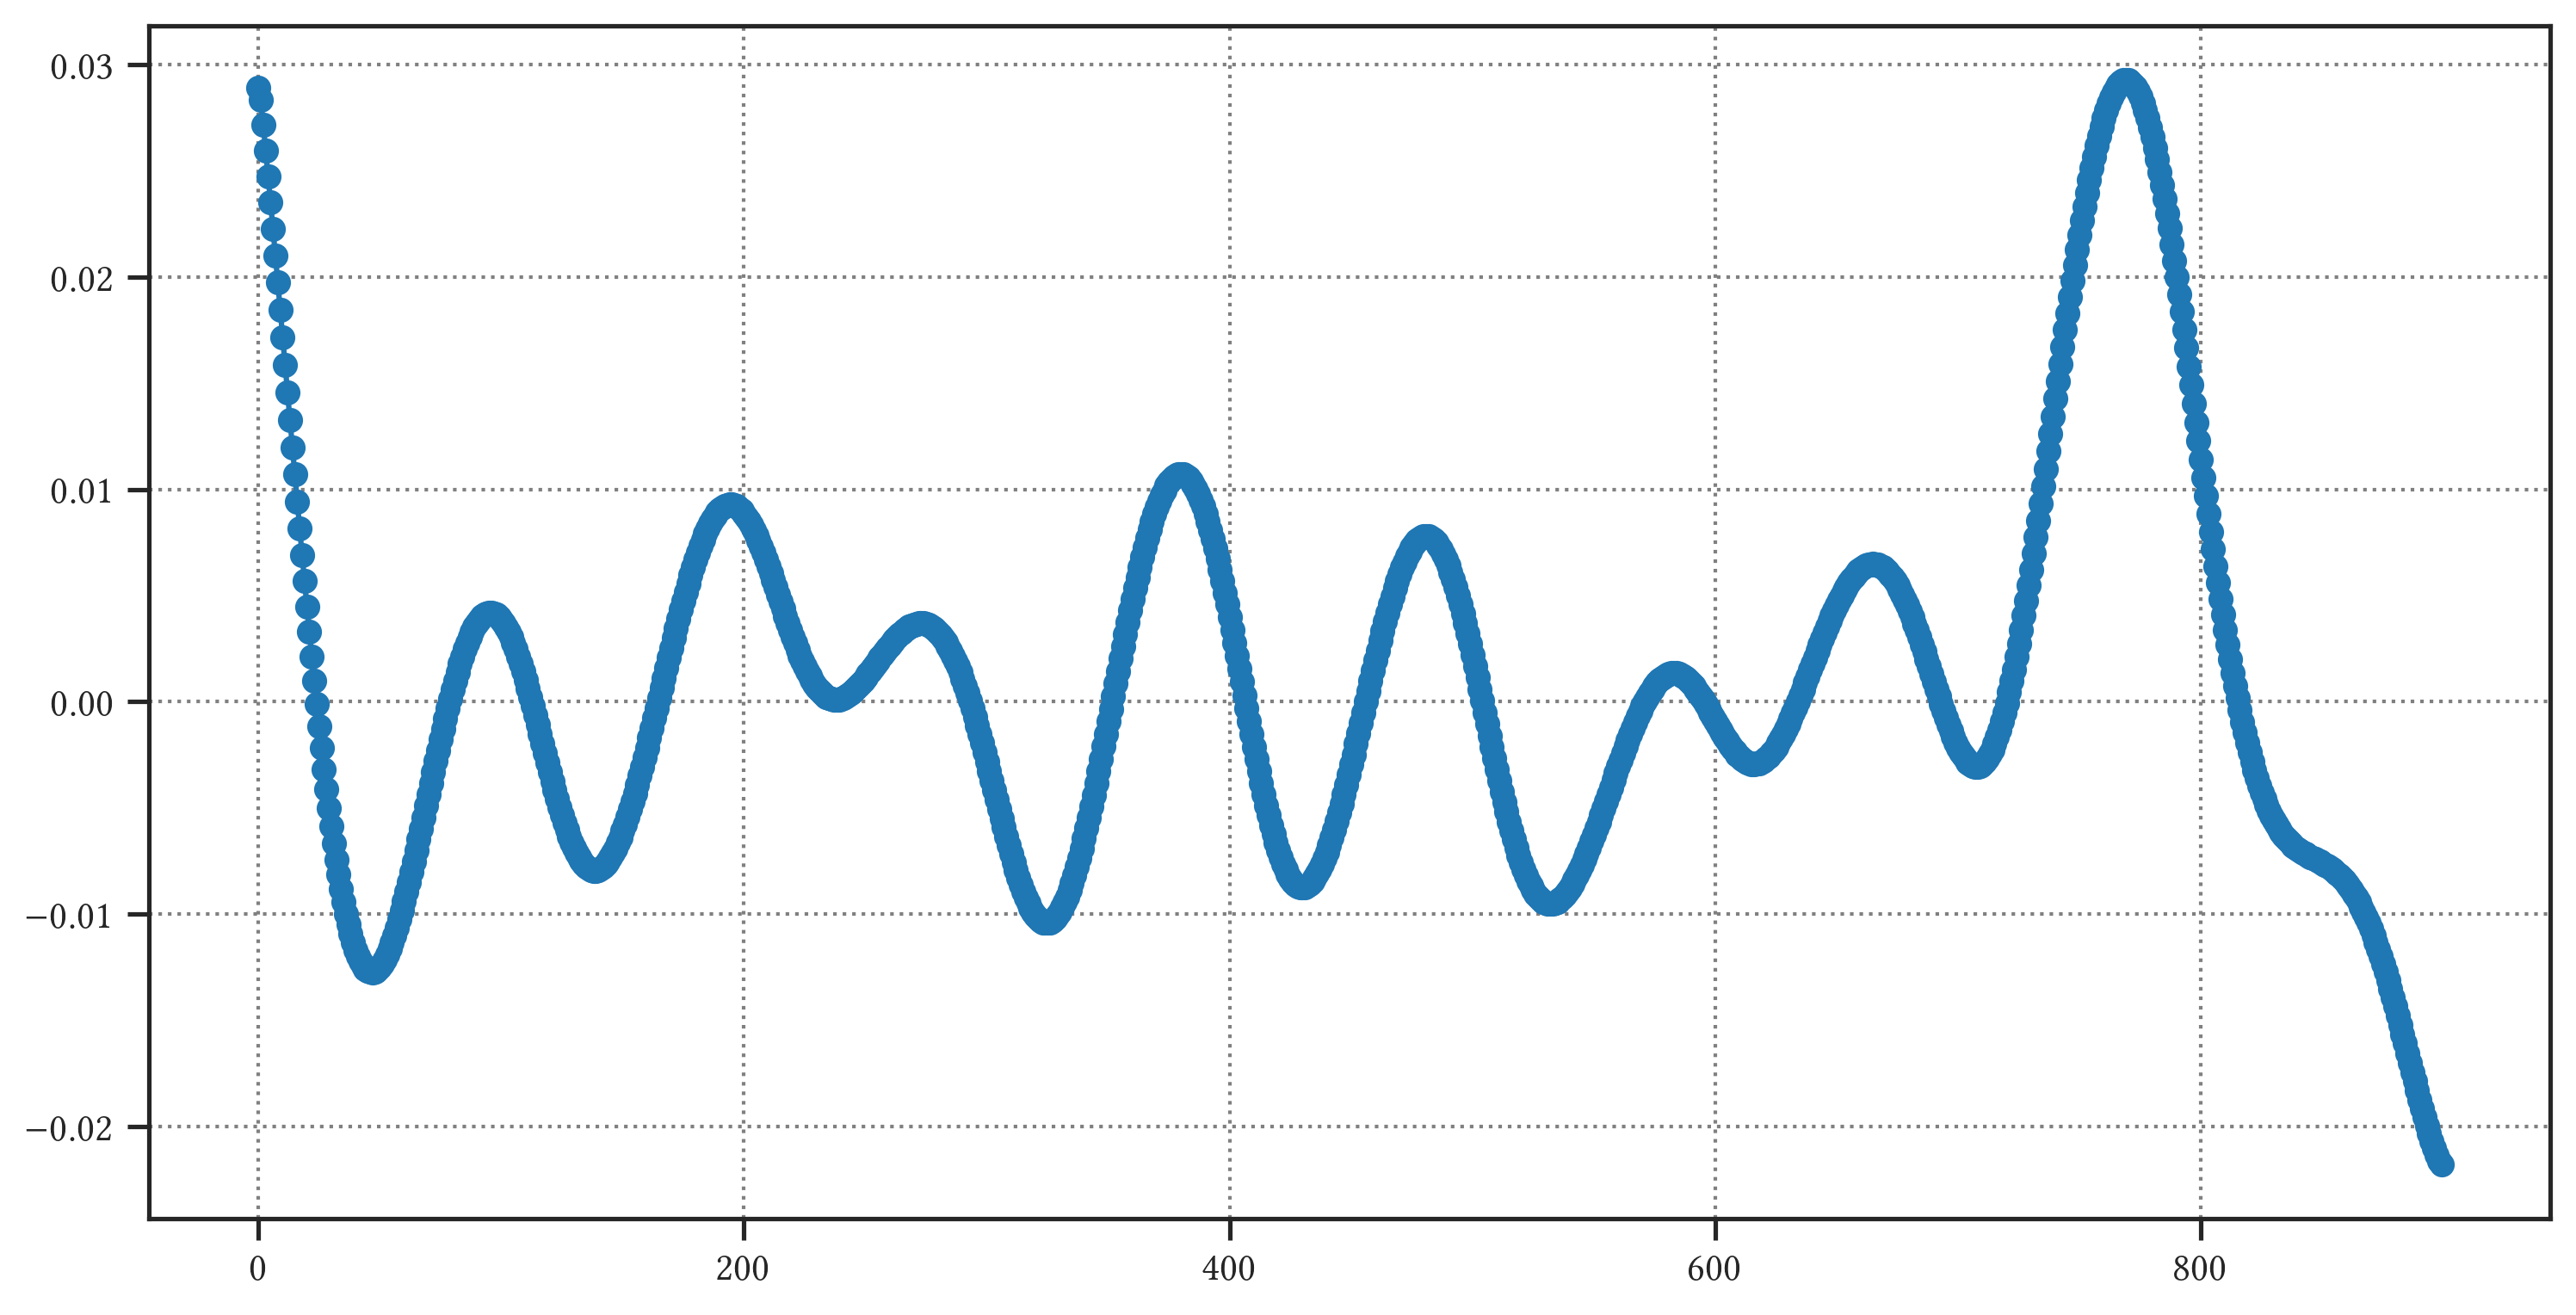

In [65]:
y_grad = np.gradient(y_mean)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_test, y_grad, 'o-')